In [1]:
import findspark

findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import isnan, when, count

In [2]:
df = spark.read.csv("nuclear_plants_small_dataset.csv", inferSchema=True, header=True)
col_names = ['Status', 'PoRS1', 'PoRS2', 'PoRS3', 'PoRS4', 'PrS1', 'PrS2', 'PrS3', 'PrS4', 'VS1', 'VS2', 'VS3', 'VS4']
df = df.toDF(*col_names)

In [3]:
df.printSchema()
df.count()

root
 |-- Status: string (nullable = true)
 |-- PoRS1: double (nullable = true)
 |-- PoRS2: double (nullable = true)
 |-- PoRS3: double (nullable = true)
 |-- PoRS4: double (nullable = true)
 |-- PrS1: double (nullable = true)
 |-- PrS2: double (nullable = true)
 |-- PrS3: double (nullable = true)
 |-- PrS4: double (nullable = true)
 |-- VS1: double (nullable = true)
 |-- VS2: double (nullable = true)
 |-- VS3: double (nullable = true)
 |-- VS4: double (nullable = true)



996

In [4]:
# Count non-numbers in all columns
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+-----+-----+-----+-----+----+----+----+----+---+---+---+---+
|Status|PoRS1|PoRS2|PoRS3|PoRS4|PrS1|PrS2|PrS3|PrS4|VS1|VS2|VS3|VS4|
+------+-----+-----+-----+-----+----+----+----+----+---+---+---+---+
|     0|    0|    0|    0|    0|   0|   0|   0|   0|  0|  0|  0|  0|
+------+-----+-----+-----+-----+----+----+----+----+---+---+---+---+



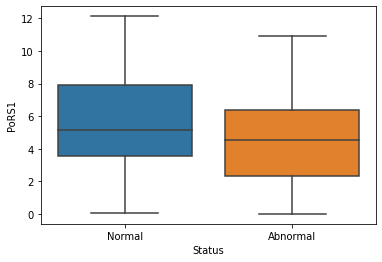

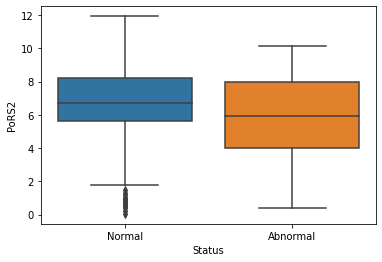

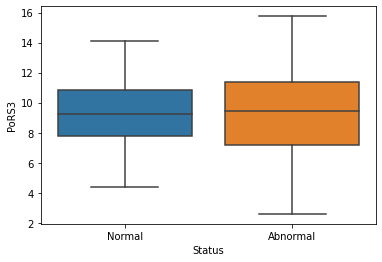

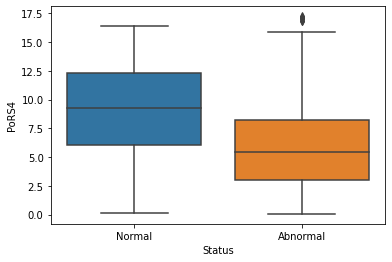

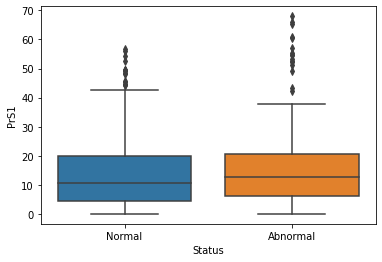

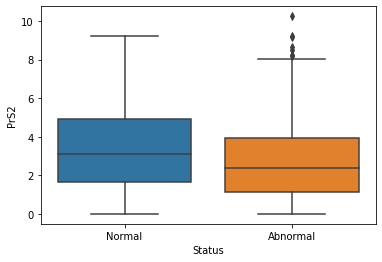

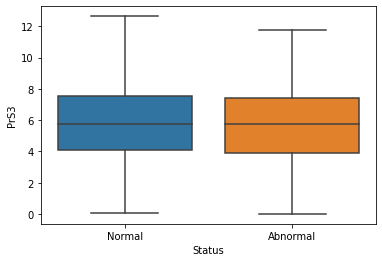

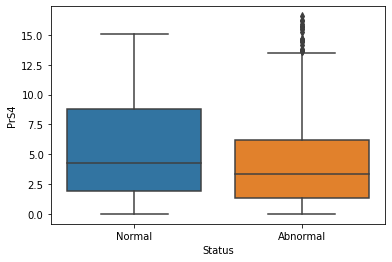

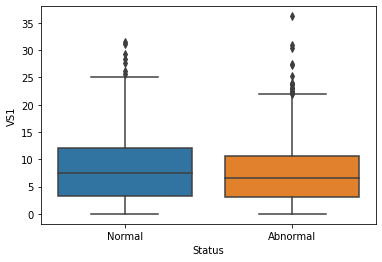

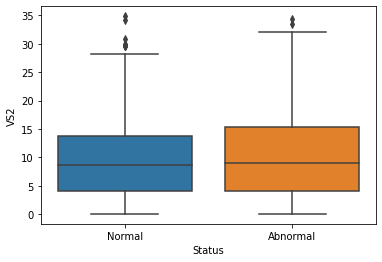

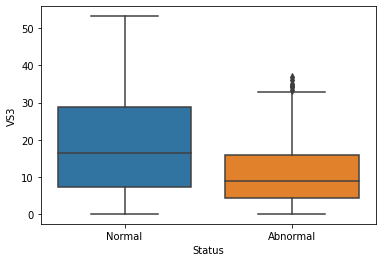

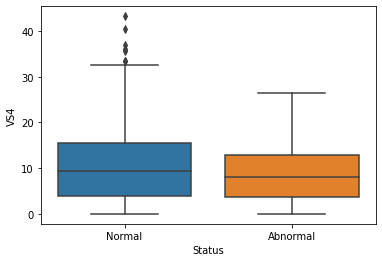

In [5]:
for col in col_names[1:]:
    sns.boxplot(x="Status", y=col, data=df.toPandas())
    plt.show()

In [6]:
for col in col_names[1:]:
    mode = df.filter(df.Status == "Normal").groupby(col).count().orderBy("count", ascending=False).first()[0]
    df_test = df.filter(df.Status == "Normal").agg(F.min(col), F.percentile_approx(f"{col}", 0.25).alias("lower percentile"), F.percentile_approx(f"{col}", 0.5).alias("median"), F.percentile_approx(f"{col}", 0.75).alias("upper percentile"), F.max(col), F.variance(col), F.mean(col)).withColumn("mode", F.lit(mode))
    df_test.show()
    
for col in col_names[1:]:
    mode = df.filter(df.Status == "Abnormal").groupby(col).count().orderBy("count", ascending=False).first()[0]
    df_test = df.filter(df.Status == "Abnormal").agg(F.min(col), F.percentile_approx(f"{col}", 0.25).alias("lower percentile"), F.percentile_approx(f"{col}", 0.5).alias("median"), F.percentile_approx(f"{col}", 0.75).alias("upper percentile"), F.max(col), F.variance(col), F.mean(col)).withColumn("mode", F.lit(mode))
    df_test.show()

+----------+----------------+------+----------------+----------+-----------------+-----------------+------+
|min(PoRS1)|lower percentile|median|upper percentile|max(PoRS1)|  var_samp(PoRS1)|       avg(PoRS1)|  mode|
+----------+----------------+------+----------------+----------+-----------------+-----------------+------+
|    0.0851|          3.5184|5.1727|          7.9193|   12.1298|8.374354492436746|5.602452811244976|8.3862|
+----------+----------------+------+----------------+----------+-----------------+-----------------+------+

+----------+----------------+------+----------------+----------+-----------------+-----------------+------+
|min(PoRS2)|lower percentile|median|upper percentile|max(PoRS2)|  var_samp(PoRS2)|       avg(PoRS2)|  mode|
+----------+----------------+------+----------------+----------+-----------------+-----------------+------+
|    0.0403|          5.6058|6.6998|          8.2022|   11.9284|4.880531200853515|6.844503413654616|8.3688|
+----------+---------------

+---------+----------------+-------+----------------+---------+------------------+------------------+---------+
|min(PrS1)|lower percentile| median|upper percentile|max(PrS1)|    var_samp(PrS1)|         avg(PrS1)|     mode|
+---------+----------------+-------+----------------+---------+------------------+------------------+---------+
| 0.131478|          6.0204|12.5912|       20.486088|  67.9794|134.42562444441973|14.600728132530124|13.090884|
+---------+----------------+-------+----------------+---------+------------------+------------------+---------+

+---------+----------------+--------+----------------+---------+-----------------+------------------+------+
|min(PrS2)|lower percentile|  median|upper percentile|max(PrS2)|   var_samp(PrS2)|         avg(PrS2)|  mode|
+---------+----------------+--------+----------------+---------+-----------------+------------------+------+
| 0.008262|        1.146072|2.380578|        3.951174|10.242738|4.014421746820416|2.7402695381526083|5.0053|
+--

In [10]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

df_data = df.drop("Status")

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_data.columns, outputCol=vector_col)
df_vector = assembler.transform(df_data).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

corr_list = matrix.head()[0].toArray().tolist()
corr_df = spark.createDataFrame(corr_list)
corr_df.show(truncate=False)

+---------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+
|_1                   |_2                  |_3                  |_4                   |_5                  |_6                   |_7                  |_8                  |_9                  |_10                  |_11                  |_12                  |
+---------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+
|1.0                  |0.0952353246570876  |0.22994307456693544 |0.49979507054382716  |0.04780506459924824 |0.6520814861476599   |0.19981099474596317 |0.40638238580405744 |-0.15224709166841371|-0.003683630548492058|0.106

In [11]:
# Let's create an exmple split of our data
(df_train, df_test) = df.randomSplit([0.7, 0.3])

In [12]:
df_train.count()

710

In [13]:
df_test.count()

286

In [14]:
# Let's import everything we need that we haven't already imported
from pyspark.ml.classification import DecisionTreeClassifier

In [15]:
# Prepare data by removing label (Status) column
features = df.columns[1:]

# Assemble feature vectors in new column
va = VectorAssembler(inputCols = features, outputCol="features")

va_df = va.transform(df_train)
va_df = va_df.select(["features", "Status"])

# Add numeric label column
va_df = va_df.withColumn(
    "label",
    F.when((F.col("Status") == "Normal"), 0)\
    .when((F.col("Status") == "Abnormal"), 1)
)
va_df.show(3)

+--------------------+--------+-----+
|            features|  Status|label|
+--------------------+--------+-----+
|[0.0394,3.4424,7....|Abnormal|    1|
|[0.108324,3.49911...|Abnormal|    1|
|[0.111078,4.11916...|Abnormal|    1|
+--------------------+--------+-----+
only showing top 3 rows



In [16]:
# Decision Tree

# Train/test split
(train, test) = va_df.randomSplit([0.7, 0.3])

# Use built-in classifier
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtc = dtc.fit(train)

pred_dt = dtc.transform(test)
pred_dt.show(10)

+--------------------+--------+-----+-------------+--------------------+----------+
|            features|  Status|label|rawPrediction|         probability|prediction|
+--------------------+--------+-----+-------------+--------------------+----------+
|[0.0861,4.8303,6....|  Normal|    0|  [28.0,37.0]|[0.43076923076923...|       1.0|
|[0.1273,8.4933,11...|Abnormal|    1|    [2.0,8.0]|           [0.2,0.8]|       1.0|
|[0.1447,5.5261,7....|  Normal|    0|  [28.0,37.0]|[0.43076923076923...|       1.0|
|[0.162,9.9188,11....|Abnormal|    1|    [2.0,8.0]|           [0.2,0.8]|       1.0|
|[0.2325,4.9466,6....|  Normal|    0|  [28.0,37.0]|[0.43076923076923...|       1.0|
|[0.2811,4.52,8.04...|  Normal|    0|  [10.0,57.0]|[0.14925373134328...|       1.0|
|[0.4724,4.9612,8....|  Normal|    0|  [10.0,57.0]|[0.14925373134328...|       1.0|
|[0.5145,3.3417,7....|Abnormal|    1|  [10.0,57.0]|[0.14925373134328...|       1.0|
|[0.616284,5.93456...|Abnormal|    1|  [10.0,57.0]|[0.14925373134328...|    

In [21]:
# SVC
from pyspark.ml.classification import LinearSVC

svc = LinearSVC(maxIter=10, regParam=0.1)

svcModel = svc.fit(train)

pred_svc = svcModel.transform(test)
pred_svc.show(3)

+--------------------+--------+-----+--------------------+----------+
|            features|  Status|label|       rawPrediction|prediction|
+--------------------+--------+-----+--------------------+----------+
|[0.0861,4.8303,6....|  Normal|    0|[-1.0850009530342...|       1.0|
|[0.1273,8.4933,11...|Abnormal|    1|[-1.6571311158129...|       1.0|
|[0.1447,5.5261,7....|  Normal|    0|[-0.8187584159358...|       1.0|
+--------------------+--------+-----+--------------------+----------+
only showing top 3 rows



In [25]:
# Artificial Nueral Network
from pyspark.ml.classification import MultilayerPerceptronClassifier

mlpc = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", layers = [12, 2], maxIter=1000, blockSize=128, seed=1234)
mlpcModel = mlpc.fit(train)

pred_mlpc = mlpcModel.transform(test)
pred_mlpc.show(3)

+--------------------+--------+-----+--------------------+--------------------+----------+
|            features|  Status|label|       rawPrediction|         probability|prediction|
+--------------------+--------+-----+--------------------+--------------------+----------+
|[0.0861,4.8303,6....|  Normal|    0|[2.82304143518889...|[0.11764528359085...|       1.0|
|[0.1273,8.4933,11...|Abnormal|    1|[-0.6130626864328...|[0.03622099379129...|       1.0|
|[0.1447,5.5261,7....|  Normal|    0|[-0.3734117360322...|[0.28200110102859...|       1.0|
+--------------------+--------+-----+--------------------+--------------------+----------+
only showing top 3 rows



In [44]:
# Evaluation
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Decision tree eval
dt_eval = pred_dt.withColumn("match", (F.when(F.col("label") == F.col("prediction"), 1).otherwise(0)))
dt_eval = dt_eval.withColumn("assessment", (\
                            F.when((F.col("label") == 1) & (F.col("prediction") == 1), "truepos")\
                            .when((F.col("label") == 0) & (F.col("prediction") == 1), "falsepos")\
                            .when((F.col("label") == 1) & (F.col("prediction") == 0), "falseneg")\
                            .when((F.col("label") == 0) & (F.col("prediction") == 0), "trueneg")\
                            .otherwise(0)
                        ))
dt_eval = dt_eval.drop("features", "rawPrediction", "probability")
dt_eval.show(3)

dt_eval_hit = dt_eval.filter(dt_eval.match == 1).count()
dt_eval_miss = dt_eval.filter(dt_eval.match == 0).count()

dt_eval_truepos = dt_eval.filter(dt_eval.assessment == "truepos").count()
dt_eval_falsepos = dt_eval.filter(dt_eval.assessment == "falsepos").count()
dt_eval_falseneg = dt_eval.filter(dt_eval.assessment == "falseneg").count()
dt_eval_trueneg = dt_eval.filter(dt_eval.assessment == "trueneg").count()

print(dt_eval_miss / dt_eval_hit) # error rate
print(dt_eval_truepos / (dt_eval_truepos + dt_eval_falseneg)) # sensitivity
print(dt_eval_trueneg / (dt_eval_trueneg + dt_eval_falsepos)) # specificity


# SVC eval
svc_eval = pred_svc.withColumn("match", (F.when(F.col("label") == F.col("prediction"), 1).otherwise(0)))
svc_eval = svc_eval.withColumn("assessment", (\
                            F.when((F.col("label") == 1) & (F.col("prediction") == 1), "truepos")\
                            .when((F.col("label") == 0) & (F.col("prediction") == 1), "falsepos")\
                            .when((F.col("label") == 1) & (F.col("prediction") == 0), "falseneg")\
                            .when((F.col("label") == 0) & (F.col("prediction") == 0), "trueneg")\
                            .otherwise(0)
                        ))
svc_eval = svc_eval.drop("features", "rawPrediction", "probability")
svc_eval.show(3)

svc_eval_hit = svc_eval.filter(svc_eval.match == 1).count()
svc_eval_miss = svc_eval.filter(svc_eval.match == 0).count()

svc_eval_truepos = svc_eval.filter(svc_eval.assessment == "truepos").count()
svc_eval_falsepos = svc_eval.filter(svc_eval.assessment == "falsepos").count()
svc_eval_falseneg = svc_eval.filter(svc_eval.assessment == "falseneg").count()
svc_eval_trueneg = svc_eval.filter(svc_eval.assessment == "trueneg").count()

print(svc_eval_miss / svc_eval_hit) # error rate for LinearSVC
print(svc_eval_truepos / (svc_eval_truepos + svc_eval_falseneg)) # sensitivity
print(svc_eval_trueneg / (svc_eval_trueneg + svc_eval_falsepos)) # specificity


# ANN eval
ann_eval = pred_mlpc.withColumn("match", (F.when(F.col("label") == F.col("prediction"), 1).otherwise(0)))
ann_eval = ann_eval.withColumn("assessment", (\
                            F.when((F.col("label") == 1) & (F.col("prediction") == 1), "truepos")\
                            .when((F.col("label") == 0) & (F.col("prediction") == 1), "falsepos")\
                            .when((F.col("label") == 1) & (F.col("prediction") == 0), "falseneg")\
                            .when((F.col("label") == 0) & (F.col("prediction") == 0), "trueneg")\
                            .otherwise(0)
                        ))
ann_eval = ann_eval.drop("features", "rawPrediction", "probability")
ann_eval.show(3)

ann_eval_hit = ann_eval.filter(ann_eval.match == 1).count()
ann_eval_miss = ann_eval.filter(ann_eval.match == 0).count()

ann_eval_truepos = ann_eval.filter(ann_eval.assessment == "truepos").count()
ann_eval_falsepos = ann_eval.filter(ann_eval.assessment == "falsepos").count()
ann_eval_falseneg = ann_eval.filter(ann_eval.assessment == "falseneg").count()
ann_eval_trueneg = ann_eval.filter(ann_eval.assessment == "trueneg").count()

print(ann_eval_miss / ann_eval_hit) # error rate for MultilayerPerceptronClassifier
print(ann_eval_truepos / (ann_eval_truepos + ann_eval_falseneg)) # sensitivity
print(ann_eval_trueneg / (ann_eval_trueneg + ann_eval_falsepos)) # specificity

+--------+-----+----------+-----+----------+
|  Status|label|prediction|match|assessment|
+--------+-----+----------+-----+----------+
|  Normal|    0|       1.0|    0|  falsepos|
|Abnormal|    1|       1.0|    1|   truepos|
|  Normal|    0|       1.0|    0|  falsepos|
+--------+-----+----------+-----+----------+
only showing top 3 rows

0.3263888888888889
0.7191011235955056
0.7843137254901961
+--------+-----+----------+-----+----------+
|  Status|label|prediction|match|assessment|
+--------+-----+----------+-----+----------+
|  Normal|    0|       1.0|    0|  falsepos|
|Abnormal|    1|       1.0|    1|   truepos|
|  Normal|    0|       1.0|    0|  falsepos|
+--------+-----+----------+-----+----------+
only showing top 3 rows

0.4580152671755725
0.8089887640449438
0.5784313725490197
+--------+-----+----------+-----+----------+
|  Status|label|prediction|match|assessment|
+--------+-----+----------+-----+----------+
|  Normal|    0|       1.0|    0|  falsepos|
|Abnormal|    1|       1.0